<hr> <h3> Credits: <a href="https://www.pyimagesearch.com/2020/03/16/detecting-covid-19-in-x-ray-images-with-keras-tensorflow-and-deep-learning/">Adrian Rosebrock</a> </h3>

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D,Dropout,Flatten,Dense,Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [15]:
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os

In [16]:
INIT_LR = 1e-3
EPOCHS = 100
BS = 8

dataset_path = "dataset"

def plot_cm(labels, predictions):
    '''
    Plot the confusion matrix
    '''
    print(classification_report(labels, predictions,
	target_names=lb.classes_))

    cm = confusion_matrix(labels, predictions)
    total = sum(sum(cm))
    acc = (cm[0, 0] + cm[1, 1]) / total
    sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
    specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
    
    print("accuracy: {:.4f}".format(acc))
    print("sensitivity: {:.4f}".format(sensitivity))
    print("specificity: {:.4f}".format(specificity))
    print()
    print('Correct Healthy Patient Detection (True Negatives): ', cm[0][0])
    print('Incorrect Covid-19 Detection (False Positives): ', cm[0][1])
    print('Incorrect Healthy Patient Detection (False Negatives): ', cm[1][0])
    print('Correct Covid-19 Detection (True Positives): ', cm[1][1])
    print('Total Patietns with Covid-19: ', np.sum(cm[1]))

    print()
    plt.figure(figsize=(7,7))
    sns.heatmap(cm, annot=True, fmt="d",linewidths=0.5)
    plt.title('Confusion matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

In [17]:
imagePaths = list(paths.list_images(dataset_path))
data = []
labels = []

# loop over the image paths
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]
	# load the image, swap color channels, and resize it to be a fixed
	# 224x224 pixels while ignoring aspect ratio
	image = cv2.imread(imagePath)
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = cv2.resize(image, (512, 512))
	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)
    
# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 1]
data = np.array(data) / 255.0
labels = np.array(labels)

In [18]:
labels

array(['covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid',
       'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid',
       'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid',
       'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid',
       'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid',
       'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid',
       'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid',
       'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid',
       'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid',
       'covid', 'covid', 'covid', 'covid', 'covid', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'no

(512, 512, 3)


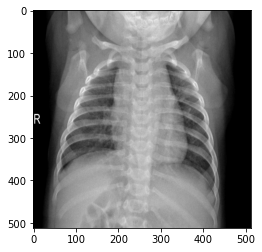

In [19]:
print(data[80].shape)
plt.imshow(data[80])

In [20]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
labels

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.

In [21]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.20, stratify=labels, random_state=3,shuffle=True)
(trainX, validX, trainY, validY) = train_test_split(trainX, trainY,test_size=0.20, stratify=trainY, random_state=3, shuffle=True)

# initialize the training data augmentation object
trainAug = ImageDataGenerator(
	rotation_range=10,
	width_shift_range=0.1,
	height_shift_range=0.1,
	shear_range=0.05,
	fill_mode="nearest")

trainAug.fit(trainX)

In [22]:
# load the VGG16 network, ensuring the head FC layer sets are left
# off
baseModel = VGG16(weights="imagenet", include_top=False,input_tensor=Input(shape=(512, 512, 3)))

# construct the top of the model that will be placed on top of the base model
topModel = baseModel.output
topModel = AveragePooling2D(pool_size=(4, 4))(topModel)
topModel = Flatten(name="flatten")(topModel)
topModel = Dense(64, activation="relu")(topModel)
topModel = Dropout(0.5)(topModel)
topModel = Dense(2, activation="softmax")(topModel)

# place the top FC model on top of the base model (this will become the actual model we will train)
model = Model(inputs=baseModel.input, outputs=topModel)

# Make all pre-trained layers from VGG19 non-trainable except last 3 layers 
for layer in baseModel.layers[:-3]:
    layer.trainable = False

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 256, 256, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 128, 128)     0   

In [23]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

early_stopping = EarlyStopping(
            monitor='loss', 
            verbose=1,
            patience=5,
            restore_best_weights=True)

model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

H = model.fit(trainAug.flow(trainX, trainY, batch_size=BS),
              validation_data=(validX, validY),
              callbacks=[early_stopping],
              epochs = EPOCHS)

  ...
    to  
  ['...']
Train for 12 steps, validate on 24 samples
Epoch 1/100
12/12 [==============================] - 9s 775ms/step - loss: 0.8466 - accuracy: 0.5699 - val_loss: 0.3705 - val_accuracy: 0.8750
Epoch 2/100
12/12 [==============================] - 8s 706ms/step - loss: 0.5229 - accuracy: 0.7742 - val_loss: 0.1720 - val_accuracy: 1.0000
Epoch 3/100
12/12 [==============================] - 8s 704ms/step - loss: 0.2839 - accuracy: 0.9355 - val_loss: 0.0039 - val_accuracy: 1.0000
Epoch 4/100
12/12 [==============================] - 8s 706ms/step - loss: 0.1597 - accuracy: 0.9355 - val_loss: 0.0395 - val_accuracy: 1.0000
Epoch 5/100
12/12 [==============================] - 8s 706ms/step - loss: 0.0611 - accuracy: 0.9892 - val_loss: 8.9445e-04 - val_accuracy: 1.0000
Epoch 6/100
12/12 [==============================] - 8s 707ms/step - loss: 0.0319 - accuracy: 0.9785 - val_loss: 0.0068 - val_accuracy: 1.0000
Epoch 7/100
12/12 [==============================] - 8s 703ms/step - l

In [24]:
# Make predictions on the testing set
predIdxs = model.predict(testX, batch_size=BS)
print('\nNumber of test scans: ', len(testX))
print('Predicted class probabilities:')
print(predIdxs)

# Find the predicted labels 
predIdxs = np.argmax(predIdxs, axis=1)
print('\nPredicted outcome (Covid=1, Normal=0):')
print(predIdxs)
print('Ground-truth outcome:')
# print(testY)
trueIdxs = np.argmax(testY, axis=1)
print(trueIdxs)


Number of test scans:  30
Predicted class probabilities:
[[2.9474360e-24 1.0000000e+00]
 [1.3802573e-29 1.0000000e+00]
 [1.0000000e+00 5.1667058e-14]
 [1.0000000e+00 1.7671297e-08]
 [7.1064634e-14 1.0000000e+00]
 [9.9993026e-01 6.9719885e-05]
 [9.9999988e-01 1.2793710e-07]
 [9.9985826e-01 1.4174412e-04]
 [1.0000000e+00 6.7810485e-10]
 [1.0000000e+00 3.6143596e-10]
 [1.0000000e+00 9.4929682e-11]
 [2.1963543e-33 1.0000000e+00]
 [1.0000000e+00 4.8443698e-09]
 [1.0000000e+00 4.1256988e-13]
 [3.1312183e-07 9.9999964e-01]
 [1.9571839e-34 1.0000000e+00]
 [3.8730687e-20 1.0000000e+00]
 [1.0283876e-30 1.0000000e+00]
 [2.6079472e-14 1.0000000e+00]
 [1.0000000e+00 2.2712682e-13]
 [5.3186221e-24 1.0000000e+00]
 [2.8376656e-27 1.0000000e+00]
 [7.3328229e-05 9.9992669e-01]
 [5.9083116e-14 1.0000000e+00]
 [9.9999857e-01 1.4670763e-06]
 [1.0000000e+00 4.2922354e-12]
 [9.8815608e-01 1.1843993e-02]
 [7.9897019e-34 1.0000000e+00]
 [2.2266805e-27 1.0000000e+00]
 [1.0000000e+00 4.0014731e-13]]

Predicted 

loss :  0.5116431223461404
accuracy :  0.96666664

              precision    recall  f1-score   support

       covid       0.93      1.00      0.97        14
      normal       1.00      0.94      0.97        16

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30

accuracy: 0.9667
sensitivity: 1.0000
specificity: 0.9375

Correct Healthy Patient Detection (True Negatives):  14
Incorrect Covid-19 Detection (False Positives):  0
Incorrect Healthy Patient Detection (False Negatives):  1
Correct Covid-19 Detection (True Positives):  15
Total Patietns with Covid-19:  16



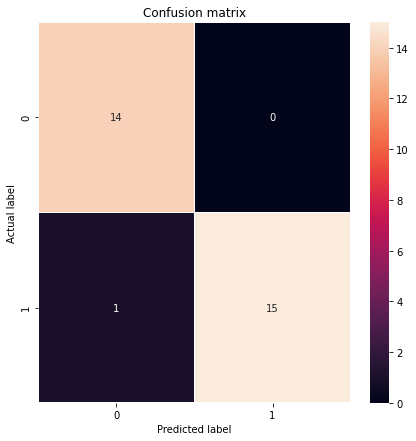

In [25]:
predicted_metrics = model.evaluate(testX, testY,batch_size=BS, verbose=0)

for name, value in zip(model.metrics_names, predicted_metrics):
  print(name, ': ', value)
print()

plot_cm(trueIdxs, predIdxs)

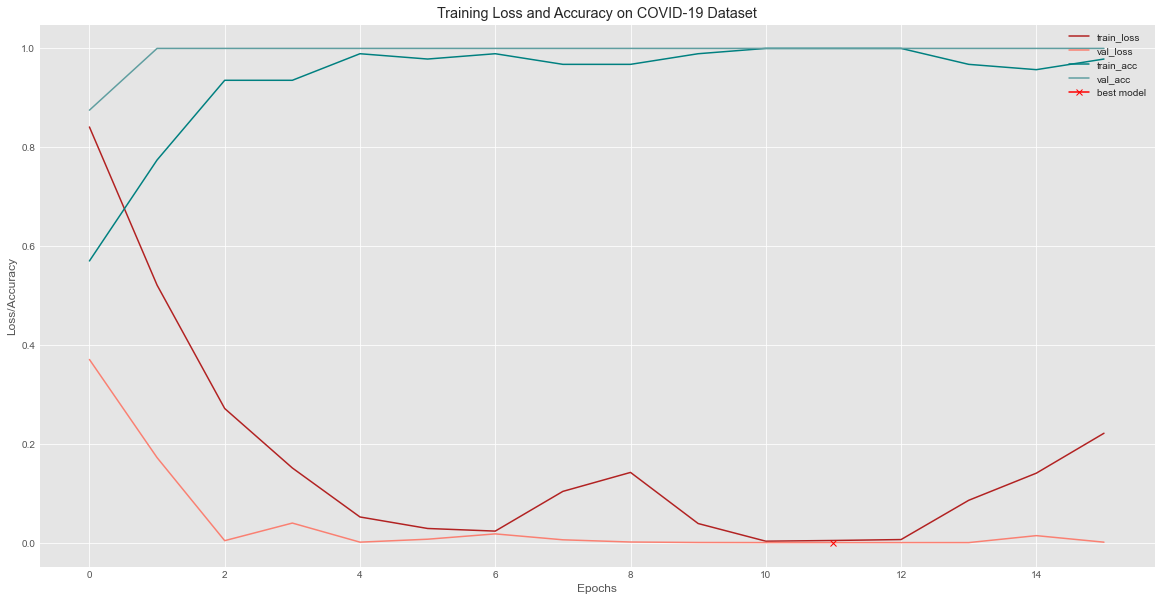

In [29]:
N = len(H.history["loss"])
plt.style.use("ggplot")
plt.figure(figsize = (20,10))
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss", color = 'firebrick')
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss", color = 'salmon')
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc", color = 'teal')
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc",color = 'cadetblue')
plt.plot( np.argmin(H.history["val_loss"]), np.min(H.history["val_loss"]), marker="x", color="r", label="best model")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")
plt.savefig('loss_curve.jpg')
plt.show()

In [37]:
model.save('x_ray.h5') 